In [ ]:
# Testing my NCA code with some emojis. Much of the code in this notebook is taken from https://github.com/miltonllera/diff-nca/blob/master/scripts/emojis.py


# Currently my code uses 4 visible inputs, change it to 3 like in the code above. 
# This is to figure out why there is such a big difference in the output.
# To be clear, i only train my NCAs for about 5000-10000 steps, whereas they use 100.000 steps, but i still would like better results.

# Also, try to rewrite for diffusion, and see current performance.

In [1]:
import os
import os.path as osp
import io
import requests

from enum import Enum
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import display, clear_output

In [2]:
class Emojis(Enum):
    BANG = "💥"
    BUTTERFLY = "🦋"
    EYE = "👁"
    FISH = "🐠"
    LADYBUG = "🐞"
    PRETZEL = "🥨"
    SALAMANDER = "🦎"
    SMILEY = "😀"
    TREE = "🎄"
    WEB = "🕸"

In [3]:
def load_image(url, max_size=40):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.LANCZOS)
    img = np.asarray(img, dtype=np.float32) / 255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img[..., :3]

def download_emoji(emoji, max_size):
    code = hex(ord(emoji))[2:].lower()
    url = f"https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u{code}.png?raw=true"
    return load_image(url, max_size)

emojiDict = {}

for emoji in Emojis:
    emojiDict[emoji.name] = torch.tensor(
        download_emoji(emoji.value, 32)
        ).permute(2, 0, 1)
    
tensor_list = list(emojiDict.values())
emojiTensor = torch.stack(tensor_list)
labelTensor = torch.arange(len(tensor_list))

torch.save((labelTensor, emojiTensor), "emojiTensors.pt")

In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labelTensor, emojiTensor = torch.load('emojiTensors.pt')
dataset = TensorDataset(labelTensor.to(device), emojiTensor.to(device))
trainDataloader = DataLoader(dataset, batch_size=10, shuffle=True)

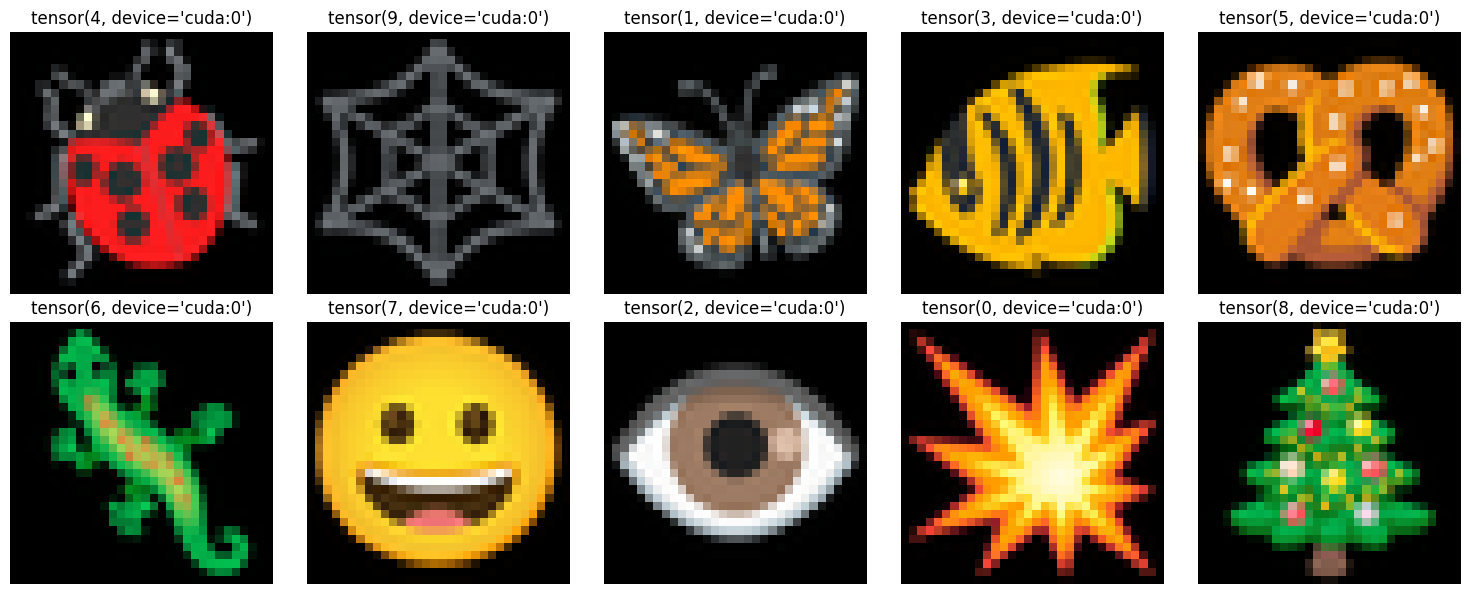

torch.Size([10, 3, 32, 32])


In [6]:
#Make sure correct data is loaded 

labels, batch = next(iter(trainDataloader))

batch_permuted = batch.permute(0, 2, 3, 1).cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, img, label in zip(axes, batch_permuted, labels):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()
print(batch.shape)

In [7]:
class NCAD(nn.Module):
    def __init__(self, visibleChannels, hiddenInputs, num_classes, conditioningChannels, timeEmbeddingChannels, ncaSteps):
        super(NCAD, self).__init__()

        self.visibleChannels = visibleChannels
        self.hiddenInputs = hiddenInputs

        inChannels = visibleChannels + hiddenInputs + conditioningChannels + timeEmbeddingChannels
        outChannels = visibleChannels + hiddenInputs
        self.channelWidth = inChannels
        hiddenChannelWidths = inChannels * 3

        self.class_emb = nn.Embedding(num_classes, conditioningChannels)
        self.time_emb = nn.Embedding(int(ncaSteps * 1.2), timeEmbeddingChannels)

        self.conv1 = nn.Conv2d(inChannels, hiddenChannelWidths, kernel_size=3, padding=1, groups=inChannels, bias=False)  # 3x3 convolution
        self.conv2 = nn.Conv2d(hiddenChannelWidths, hiddenChannelWidths, kernel_size=1)
        self.conv3 = nn.Conv2d(hiddenChannelWidths, hiddenChannelWidths, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(hiddenChannelWidths, outChannels, kernel_size=1, bias=False) # 1x1 convolution      

        self.guidance_prob = 0.1
        self.cell_fire_rate = 0.5

    def forward(self, inp, t, class_labels):
        bs, ch, w, h = inp.shape

        class_cond = self.class_emb(class_labels)
        batch_size, embed_dim = class_cond.shape
        mask = torch.rand(batch_size, device=class_cond.device) < self.guidance_prob # should the < be turned around?
        class_cond[mask] = torch.zeros(embed_dim, device=class_cond.device) #Guidance
        conditioning = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)

        t_cond = self.time_emb(t)
        time_cond = t_cond.view(1, t_cond.shape[0], 1, 1).expand(bs, t_cond.shape[0], w, h)

        x = torch.cat([inp, conditioning, time_cond], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        
        #Stochastsic update, inspired by: https://github.com/shyamsn97/controllable-ncas/blob/master/controllable_nca/nca.py
        updateMask = (
            torch.clamp(
                torch.rand_like(x[:, 0:1], device=x.device), 0.0, 1.0).float()
            < self.cell_fire_rate).float()
        
        return inp + x  * updateMask

In [8]:
diffusionSteps = 64 # ~timesteps
model = NCAD(
    visibleChannels=3, 
    hiddenInputs=17, 
    num_classes=10, 
    conditioningChannels=8, 
    timeEmbeddingChannels=4,
    ncaSteps=diffusionSteps).to(device)
losses = {}
Op = torch.optim.Adam(model.parameters(), lr=1e-4)

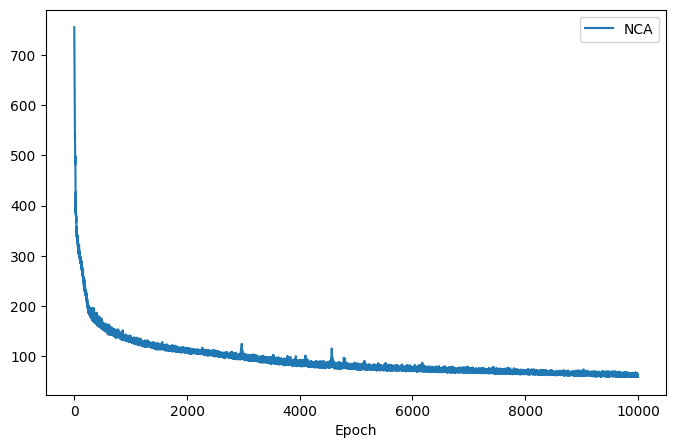

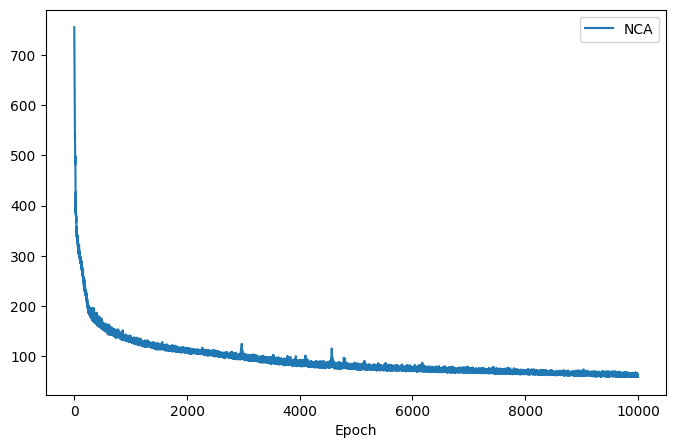

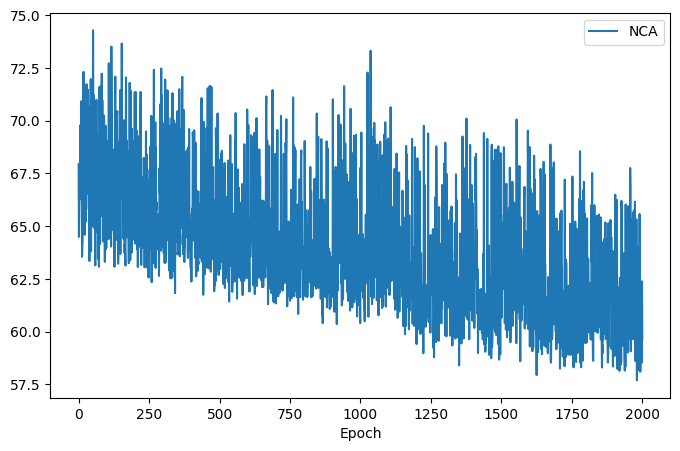

In [10]:
def trainModelForward(ncaModel, lossDict, id, ncaSteps, epochs, optimizer, dataset):
    ncaModel.train()

    fig, ax = plt.subplots(figsize=(8, 5))
    display(fig)
    lossDict[id] = []
    loss_fn = nn.MSELoss(reduction='sum')

    for epoch in range(epochs):
        optimizer.zero_grad()

        for labels, batch in dataset:
            stepsRange = int(ncaSteps * 0.2) #Add +- 20%
            steps = ncaSteps + torch.randint(-stepsRange, stepsRange, (1,), device=device).item()
            timesteps = torch.linspace(steps - 1, 0, steps, device=device).long() 

            x_vis = torch.randn_like(batch, device=device)
            # Use a non zero value for initialization, so the nca can differntiate between the values and padded edges
            x_hidden = torch.full((batch.shape[0], ncaModel.hiddenInputs, batch.shape[2], batch.shape[3]), 0.5, device=device)
            x_t = torch.concat((x_vis, x_hidden), dim=1)

            for t in timesteps:
                x_t = ncaModel(x_t, t, labels)

            Loss = loss_fn(F.sigmoid(x_t[:, :ncaModel.visibleChannels]), batch) / batch.shape[0]
            Loss.backward()
            optimizer.step()

            lossDict[id].append(Loss.item())
        if epoch % 10 == 0:
            clear_output(wait=True)  
            ax.clear()
            plt.plot(lossDict[id][:], label=id)
            plt.legend()
            plt.xlabel('Epoch')
            display(fig)
            
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(lossDict[id][int(epochs*0.8):], label=id)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    return model, losses

model, losses = trainModelForward(model, losses, 'NCA', diffusionSteps, 10001, Op, trainDataloader)

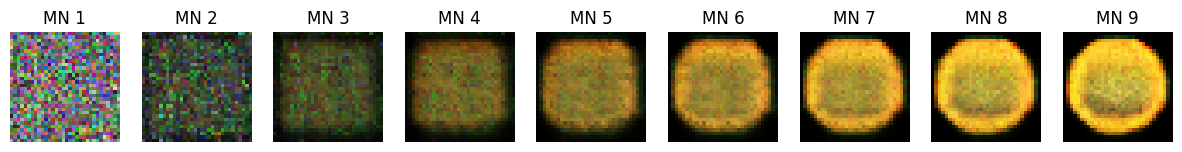

In [16]:
# Inference of trained models 
evaluatedModel = model
inferenceSteps = diffusionSteps
label = torch.tensor([7], device=device)

evaluatedModel.eval()


with torch.no_grad():
    x_vis = torch.randn((1, evaluatedModel.visibleChannels, 32, 32), device=device)
    x_hidden = torch.full((1, evaluatedModel.hiddenInputs, 32, 32), 0.5, device=device)

    x_t = torch.concat((x_vis, x_hidden), dim=1)

    intermediateImages = []

    timesteps = torch.linspace(inferenceSteps - 1, 0, inferenceSteps, device=device).long()
    

    for i, t in enumerate(timesteps):
        x_t = evaluatedModel(x_t, t, label)

        if i % int(inferenceSteps / 8)  == 0:
            intermediateImages.append(F.sigmoid(x_t).cpu().numpy())
    x_t = F.sigmoid(x_t)

    #Might be a duplicate from last step
    intermediateImages.append(x_t.cpu().numpy())

numColumns = len(intermediateImages)
fig, axs = plt.subplots(1, numColumns, figsize=(15, 3))

# Plot images
for col, img in enumerate(intermediateImages):
    axs[ col].imshow(img[0,:evaluatedModel.visibleChannels].transpose(1, 2, 0))
    axs[ col].axis('off')  
    axs[ col].set_title(f"{'MN'} {col+1}")  


In [97]:
# optionally save or load models:
torch.save(model.state_dict(), "emoji64NCA_10_000.pth")
#model.load_state_dict(torch.load("emojiNCA.pth"))
